In [1]:
import pyabf
import numpy as np
from scipy.signal import savgol_filter, bessel, filtfilt
import matplotlib.pyplot as plt
import sys
import os
%matplotlib inline

Bad key text.latex.preview in file c:\Users\SMest\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution
Bad key mathtext.fallback_to_cm in file c:\Users\SMest\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution
Bad key savefig.jpeg_quality in file c:\Users\SMest\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably

In [6]:
# Load the ABF file
abf = pyabf.ABF(os.path.expanduser("~/dropbox/20/240320_0015.abf"))

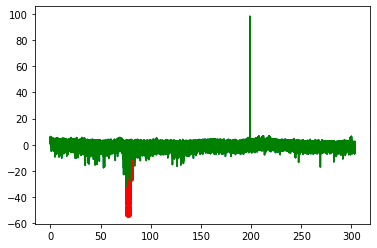

In [7]:
# Get the sweep data
sweep = 0
abf.setSweep(sweep, channel=0)
data = abf.sweepY
stim = abf.sweepC
time = abf.sweepX
sr = abf.dataRate

#baseline correction via linear regression
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(time, data)
data = data - (slope*time + intercept)

# apply a low pass filter to 1hz
# design the filter
b, a = bessel(4, 1, 'low', fs=sr)
# apply the filter
data_base = filtfilt(b, a, data)
# find periods where the data is 3 standard deviations above or below the mean in the filtered data
mean = 0.0
thresh = 5
idx_fail = np.where(np.logical_or(data_base > mean + thresh, data_base < mean - thresh))[0]

#plot
plt.plot(time, data)
plt.plot(idx_fail/sr, data[idx_fail], 'ro')

data_adjusted = data.copy()
data_adjusted[idx_fail] = 0
plt.plot(time, data_adjusted, c='g')

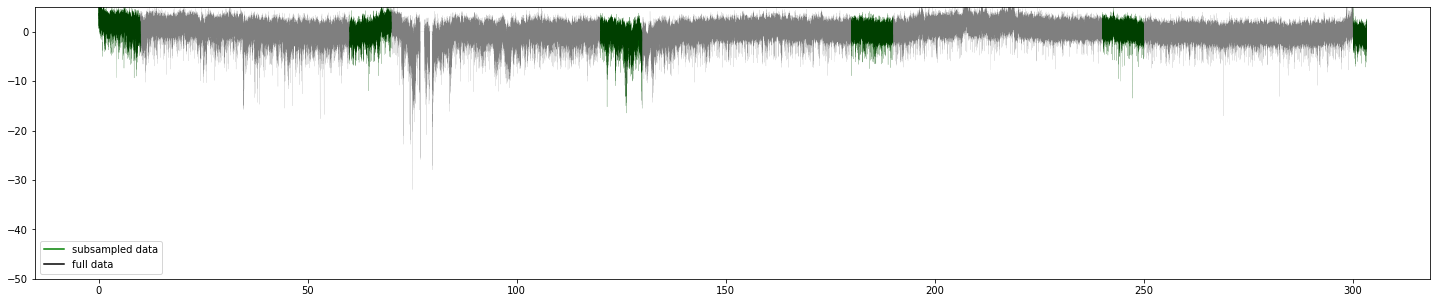

In [16]:
#now get the full run_time  of the data
run_time = time[-1]
subsample_window = 10*sr # 10 seconds
subsample_step = 60*sr # 5 seconds
subsampled_data = []
subsampled_time = []
plt.figure(figsize=(25, 5))
for i in range(0, len(data), subsample_step):
    subsampled_data.append(data_adjusted[i:i+subsample_window])
    subsampled_time.append(time[i:i+subsample_window])
    plt.plot(time[i:i+subsample_window], data_adjusted[i:i+subsample_window], 'g', lw=0.1)
plt.plot(time, data_adjusted, 'k', alpha=0.5, lw=0.1,)
plt.plot([], [], 'g', label='subsampled data')
plt.plot([], [], 'k', label='full data')
plt.legend()
plt.ylim(-50, 5)
#plt.xlim(0, run_time)
plt.show()


In [5]:
#now we need to save the data as individual abf files
from pyabf.abfWriter import writeABF1

def make_or_get_fold(fold):
    if not os.path.exists(fold):
        os.makedirs(fold)
    return fold


base_name = os.path.basename(abf.abfFilePath).split('.')[0]
dir_name = make_or_get_fold(os.path.join(os.path.dirname(abf.abfFilePath), f"{base_name}_subsampled"))
data_out = {}
for d, t in zip(subsampled_data, subsampled_time):
    writeABF1(filename=f"{dir_name}/{base_name}_{t[0]:.0f}.abf", sweepData=d.reshape(-1, 1), units='pA', sampleRateHz=sr)
    data_out[f"{base_name}_{t[0]:.0f}.abf"] = {'time_start': t[0], 'time_end': t[-1]}

#save the data_out
import pandas as pd
df = pd.DataFrame(data_out).T
df.to_csv(f"{dir_name}/{base_name}_data.csv")